[Guide on Unbalanced datasets 💸SMOTE, PCA and NN🤖](https://www.kaggle.com/code/ludovicocuoghi/guide-on-unbalanced-datasets-smote-pca-and-nn)

# Colab 과 Kaggle 연동

### kaggle token 업로드

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"woonmoon","key":"350eb9712b76ed4e660bda7d4f99e7eb"}'}

In [2]:
# json 파일 이동
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json
# 내가 참가한 대회 리스트 확인
!kaggle competitions list

ref                                             deadline             category            reward  teamCount  userHasEntered  
----------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                    2030-07-01 23:59:00  Getting Started     Prizes         68           False  
gan-getting-started                             2030-07-01 23:59:00  Getting Started     Prizes         99           False  
store-sales-time-series-forecasting             2030-06-30 23:59:00  Getting Started  Knowledge        734           False  
tpu-getting-started                             2030-06-03 23:59:00  Getting Started  Knowledge        145           False  
digit-recognizer                                2030-01-01 00:00:00  Getting Started  Knowledge       1211           False  
titanic                                         2030-01-01 00:00:00  Getting Started  Knowledge      14010            True  


In [3]:
! kaggle datasets download -d mlg-ulb/creditcardfraud

 67% 44.0M/66.0M [00:00<00:00, 243MB/s]
100% 66.0M/66.0M [00:00<00:00, 221MB/s]


# Library

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing & Cleansing

In [5]:
# Data Load
df = pd.read_csv('/content/creditcardfraud.zip', skipinitialspace=True)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
def check_data(data):
    df = pd.DataFrame(data.dtypes)
    df.columns = ['Dtypes']
    df['Null'] = [data[i].isnull().sum() for i in data.columns]
    df['Nuniques'] = [data[i].nunique() for i in data.columns]
    return df

check_data(df)

,Dtypes,Null,Nuniques
Time,float64,0,124592
V1,float64,0,275663
V2,float64,0,275663
V3,float64,0,275663
V4,float64,0,275663
V5,float64,0,275663
V6,float64,0,275663
V7,float64,0,275663
V8,float64,0,275663
V9,float64,0,275663


In [7]:
# class의 개수가 맞지 않음 => resampling 필요할 듯
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

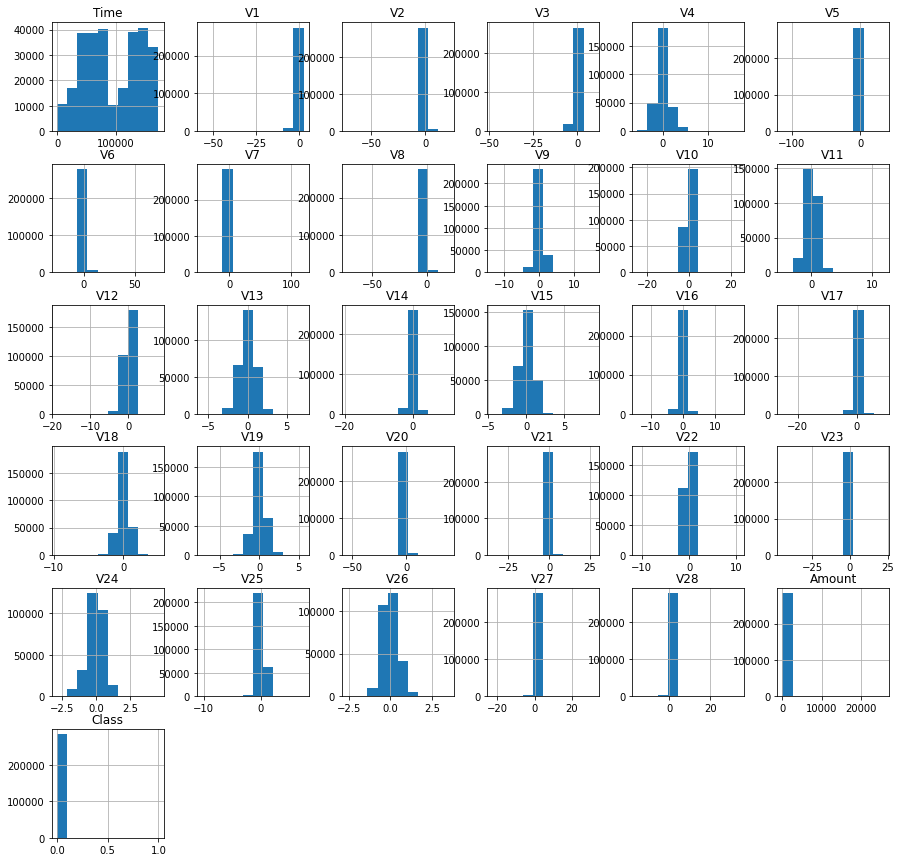

In [8]:
df.hist(figsize=(15,15));

### StandardScaler

In [9]:
# scaling amount and time
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['Amount_ss'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

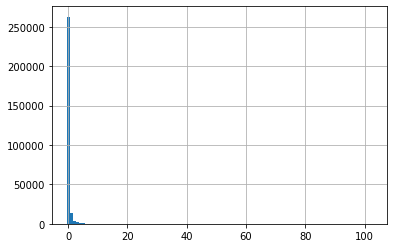

In [10]:
df['Amount_ss'].hist(bins=100);

### 로그 변환

In [11]:
# df['Amount'].hist(bins=100);

In [12]:
# df['Amount_log1p'] = np.log1p(df['Amount'])
# df['Amount_log1p'].hist(bins=100);

# Resampling

In [13]:
# label_name
df = df.drop(columns=['Amount', 'Time'])
label_name = 'Class'

In [14]:
# X, y 만들기
X = df.drop(columns=[label_name])
y = df[label_name]
X.shape, y.shape

((284807, 29), (284807,))

### Under-Sampling

In [15]:
df_0 = df[df['Class'] == 0].sample(n=492, 
                                   random_state=42)
df_1 = df[df['Class'] == 1]
df_0.shape, df_1.shape

((492, 30), (492, 30))

In [16]:
df_under = pd.concat([df_0, df_1], ignore_index=True)
df_under['Class'].value_counts(), df_under.shape

(0    492
 1    492
 Name: Class, dtype: int64, (984, 30))

### Over-Sampling

In [17]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_over, y_over = sm.fit_resample(X, y)

In [18]:
# X shape
X.shape, X_over.shape

((284807, 29), (568630, 29))

In [19]:
# y shape
y.shape, y_over.shape

((284807,), (568630,))

# Base Model & 학습

## 기존 데이터

In [20]:
# sklearn.model_selection 으로 데이터셋 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

print(f'X_train : {X_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

X_train : (227845, 29)
X_test : (56962, 29)
y_train : (227845,)
y_test : (56962,)


### NN BaseModel

In [21]:
import tensorflow as tf
input_shape = X_train.shape[1]
input_shape

29

In [22]:
# tf.keras.models.Sequential 로 입력-히든-출력(sigmoid) 레이어로 구성
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(units=128, input_shape=[input_shape]))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 출력층

model

In [23]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
# 모델 요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3840      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 20,481
Trainable params: 20,481
Non-trainable params: 0
_________________________________________________________________


In [25]:
# 학습하기

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)

history = model.fit(X_train, y_train, epochs=100, validation_split=0.3,
                    callbacks=early_stop, verbose=0)


In [26]:
# 학습결과의 history 값을 가져와서 비교하기 위해 데이터프레임으로 변환
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,accuracy,val_loss,val_accuracy
32,0.003046,0.999298,0.006347,0.999415
33,0.002788,0.999329,0.006946,0.999386
34,0.003570,0.999291,0.006544,0.999298
35,0.003386,0.999304,0.006427,0.999283
36,0.002883,0.999273,0.006623,0.999386


In [27]:
y_pred = model.predict(X_test)
y_predict = (y_pred.flatten() > 0.5).astype(int)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_predict))

1781/1781 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.71      0.84      0.77        98

    accuracy                           1.00     56962
   macro avg       0.85      0.92      0.88     56962
weighted avg       1.00      1.00      1.00     56962



### NN - precision /// 실패

In [28]:
import tensorflow as tf
input_shape = X_train.shape[1]
input_shape

29

In [29]:
# tf.keras.models.Sequential 로 입력-히든-출력(sigmoid) 레이어로 구성
model_precision = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(units=128, input_shape=[input_shape]))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 출력층

model

In [30]:
# 모델 컴파일
model_precision.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['precision'])

In [31]:
# 모델 요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3840      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
 dense_3 (Dense)             (None, 128)               256       
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [32]:
# 학습하기

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=30)

history = model_precision.fit(X_train, y_train, epochs=100, validation_split=0.2,
                              callbacks=early_stop, verbose=0)


ValueError: ignored

In [ ]:
# 학습결과의 history 값을 가져와서 비교하기 위해 데이터프레임으로 변환
df_hist = pd.DataFrame(history.history)
df_hist.tail()

In [ ]:
y_pred = model.predict(X_test)
y_predict = (y_pred.flatten() > 0.5).astype(int)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_predict))

### 언더샘플링

In [33]:
# X, y 만들기
X_under = df_under.drop(columns=label_name)
y_under = df_under[label_name]
X_under.shape, y_under.shape

((984, 29), (984,))

In [34]:
# sklearn.model_selection 으로 데이터셋 나누기
from sklearn.model_selection import train_test_split

X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under, y_under,
                                                                            test_size=0.2,
                                                                            random_state=42,
                                                                            stratify=y_under)

print(f'X_train : {X_under_train.shape}')
print(f'X_test : {X_under_test.shape}')
print(f'y_train : {y_under_train.shape}')
print(f'y_test : {y_under_test.shape}')

X_train : (787, 29)
X_test : (197, 29)
y_train : (787,)
y_test : (197,)


In [40]:
model_under = tf.keras.models.Sequential()

model_under.add(tf.keras.layers.Dense(units=128, input_shape=[input_shape]))
model_under.add(tf.keras.layers.Dense(128, activation='relu'))
model_under.add(tf.keras.layers.Dropout(0.2))
model_under.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 출력층

model_under.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [41]:
# 학습하기

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)

history_under = model_under.fit(X_under_train, y_under_train, epochs=1000, validation_split=0.3,
                                callbacks=early_stop, verbose=0)


In [42]:
# 학습결과의 history 값을 가져와서 비교하기 위해 데이터프레임으로 변환
df_hist_under = pd.DataFrame(history_under.history)
df_hist_under.tail()

,loss,accuracy,val_loss,val_accuracy
35,0.025061,0.992727,0.280212,0.915612
36,0.022673,0.992727,0.286176,0.915612
37,0.025117,0.992727,0.281154,0.919831
38,0.023705,0.994545,0.231049,0.936709
39,0.022735,0.994545,0.243508,0.932489


In [45]:
y_pred_under = model_under.predict(X_under_test)
y_predict_under = (y_pred_under.flatten() > 0.5).astype(int)

print(classification_report(y_under_test, y_predict_under))

7/7 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        99
           1       0.93      0.96      0.94        98

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197



### 오버샘플링 

In [46]:
# sklearn.model_selection 으로 데이터셋 나누기
from sklearn.model_selection import train_test_split

X_over_train, X_over_test, y_over_train, y_over_test = train_test_split(X_over, y_over,
                                                                        test_size=0.2,
                                                                        random_state=42,
                                                                        stratify=y_over)

print(f'X_train : {X_over_train.shape}')
print(f'X_test : {X_over_test.shape}')
print(f'y_train : {y_over_train.shape}')
print(f'y_test : {y_over_test.shape}')

X_train : (454904, 29)
X_test : (113726, 29)
y_train : (454904,)
y_test : (113726,)


In [47]:
model_over = tf.keras.models.Sequential()

model_over.add(tf.keras.layers.Dense(units=128, input_shape=[input_shape]))
model_over.add(tf.keras.layers.Dense(128, activation='relu'))
model_over.add(tf.keras.layers.Dropout(0.2))
model_over.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 출력층

model_over.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [48]:
# 학습하기

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)

history_over = model_over.fit(X_over_train, y_over_train, epochs=1000, validation_split=0.3,
                              callbacks=early_stop, verbose=0)


In [49]:
# 학습결과의 history 값을 가져와서 비교하기 위해 데이터프레임으로 변환
df_hist_over = pd.DataFrame(history_over.history)
df_hist_over.tail()

,loss,accuracy,val_loss,val_accuracy
191,0.002631,0.999589,0.002516,0.999648
192,0.002895,0.999651,0.002501,0.999641
193,0.003031,0.999585,0.001774,0.999744
194,0.002420,0.999626,0.001880,0.999707
195,0.003293,0.999661,0.001692,0.999729


In [50]:
y_pred_over = model_over.predict(X_over_test)
y_predict_over = (y_pred_over.flatten() > 0.5).astype(int)

print(classification_report(y_over_test, y_predict_over))

3554/3554 [==============================] - 5s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

